In [1]:
import cv2
import os

base_path = "E:/2024t2/5925/violence-detection-dataset"
folders = ["high-level violence", "low-level violence", "non-violence"]

for folder in folders:
    folder_path = os.path.join(base_path, folder)
    frame_save_path = os.path.join(base_path, folder + "_frames")
    if not os.path.exists(frame_save_path):
        os.makedirs(frame_save_path)

    for video_file in os.listdir(folder_path):
        if video_file.endswith(".mp4"):
            video_path = os.path.join(folder_path, video_file)
            cap = cv2.VideoCapture(video_path)
            
    
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_interval = int(fps / 3) 

            frame_count = 0
            success, frame = cap.read()
            while success:
                if frame_count % frame_interval == 0:
                   
                    frame_folder = os.path.join(frame_save_path, os.path.splitext(video_file)[0] + "_frames")
                    if not os.path.exists(frame_folder):
                        os.makedirs(frame_folder)
                    
                    frame_file = os.path.join(frame_folder, f"frame_{frame_count}.jpg")
                    cv2.imwrite(frame_file, frame)
                success, frame = cap.read()
                frame_count += 1

            cap.release()


In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, LSTM, TimeDistributed

base_path = "E:/2024t2/5925/violence-detection-dataset"
folders = ["high-level violence_frames", "low-level violence_frames", "non-violence_frames"]
labels = {"high-level violence_frames": 0, "low-level violence_frames": 1, "non-violence_frames": 2}

def load_data(folders, labels, base_path, frame_count=10):
    data = []
    targets = []

    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        for video_folder in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_folder)
            frames = []
            for frame_file in sorted(os.listdir(video_path))[:frame_count]:
                frame_path = os.path.join(video_path, frame_file)
                frame = cv2.imread(frame_path)
                frame = cv2.resize(frame, (64, 64))  
                frames.append(frame)
            if len(frames) < frame_count:
                frames.extend([np.zeros_like(frames[0])]*(frame_count - len(frames)))
            data.append(frames)
            targets.append(labels[folder])
    
    return np.array(data), np.array(targets)

data, targets = load_data(folders, labels, base_path)
data = np.expand_dims(data, axis=-1) 

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, targets, test_size=0.3, random_state=42)

def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling3D((2, 2, 2))(x)
    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D((2, 2, 2))(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(64)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

input_shape = (10, 64, 64, 3) 
num_classes = 3

model = create_model(input_shape, num_classes)
model.summary()

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=16)

model.save('violence_detection_model.h5')

print("finished training and saving as: violence_detection_model.h5")


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 64, 64, 3)]   0         
                                                                 
 conv3d (Conv3D)             (None, 10, 64, 64, 32)    2624      
                                                                 
 max_pooling3d (MaxPooling3  (None, 5, 32, 32, 32)     0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 5, 32, 32, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 2, 16, 16, 64)     0         
 g3D)                                                            
                                                                 
 time_distributed (TimeDist  (None, 2, 16384)          0     

c:\ProgramData\anaconda3\envs\comp9517\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, LSTM, TimeDistributed

base_path = "E:/2024t2/5925/violence-detection-dataset"
folders = ["high-level violence_frames", "low-level violence_frames", "non-violence_frames"]
labels = {"high-level violence_frames": 0, "low-level violence_frames": 1, "non-violence_frames": 2} 

def load_data(folders, labels, base_path, frame_count=10):
    data = []
    targets = []

    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        for video_folder in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_folder)
            frames = []
            for frame_file in sorted(os.listdir(video_path))[:frame_count]:
                frame_path = os.path.join(video_path, frame_file)
                frame = cv2.imread(frame_path)
                frame = cv2.resize(frame, (64, 64))  
                frames.append(frame)
            if len(frames) < frame_count:
                frames.extend([np.zeros_like(frames[0])]*(frame_count - len(frames)))
            data.append(frames)
            targets.append(labels[folder])
    
    return np.array(data), np.array(targets)

data, targets = load_data(folders, labels, base_path)
data = np.expand_dims(data, axis=-1) 

data = data / 255.0 

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(data, targets, test_size=0.3, random_state=42)

def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling3D((2, 2, 2))(x)
    x = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D((2, 2, 2))(x)
    x = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D((2, 2, 2))(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(128)(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


input_shape = (10, 64, 64, 3) 
num_classes = 3

model = create_model(input_shape, num_classes)
model.summary()

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

model.save('violence_detection_model.h6')

print("finished training and saving as: violence_detection_model.h6")


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 64, 64, 3)]   0         
                                                                 
 conv3d_2 (Conv3D)           (None, 10, 64, 64, 64)    5248      
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 5, 32, 32, 64)     0         
 g3D)                                                            
                                                                 
 conv3d_3 (Conv3D)           (None, 5, 32, 32, 128)    221312    
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 2, 16, 16, 128)    0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 2, 16, 16, 256)    8849

In [8]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, LSTM, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

base_path = "E:/2024t2/5925/violence-detection-dataset"
folders = ["high-level violence_frames", "low-level violence_frames", "non-violence_frames"]
labels = {"high-level violence_frames": 0, "low-level violence_frames": 1, "non-violence_frames": 2}

def load_data(folders, labels, base_path, frame_count=10):
    data = []
    targets = []

    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        for video_folder in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_folder)
            frames = []
            for frame_file in sorted(os.listdir(video_path))[:frame_count]:
                frame_path = os.path.join(video_path, frame_file)
                frame = cv2.imread(frame_path)
                frame = cv2.resize(frame, (64, 64))  
                frames.append(frame)
            if len(frames) < frame_count:
                frames.extend([np.zeros_like(frames[0])]*(frame_count - len(frames)))
            data.append(frames)
            targets.append(labels[folder])
    
    return np.array(data), np.array(targets)

data, targets = load_data(folders, labels, base_path)
data = np.expand_dims(data, axis=-1) 

data = data / 255.0 

X_train, X_val, y_train, y_val = train_test_split(data, targets, test_size=0.3, random_state=42)

def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling3D((2, 2, 2))(x)
    x = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D((2, 2, 2))(x)
    x = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(x)
    x = MaxPooling3D((2, 2, 2))(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(128)(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

input_shape = (10, 64, 64, 3)
num_classes = 3

model = create_model(input_shape, num_classes)
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16, callbacks=[early_stopping])

model.save('violence_detection_model.h7')

print("Finished training and saved as: violence_detection_model.h7")


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 10, 64, 64, 3)]   0         
                                                                 
 conv3d_11 (Conv3D)          (None, 10, 64, 64, 64)    5248      
                                                                 
 max_pooling3d_11 (MaxPooli  (None, 5, 32, 32, 64)     0         
 ng3D)                                                           
                                                                 
 conv3d_12 (Conv3D)          (None, 5, 32, 32, 128)    221312    
                                                                 
 max_pooling3d_12 (MaxPooli  (None, 2, 16, 16, 128)    0         
 ng3D)                                                           
                                                                 
 conv3d_13 (Conv3D)          (None, 2, 16, 16, 256)    8849

INFO:tensorflow:Assets written to: violence_detection_model.h7\assets


Finished training and saved as: violence_detection_model.h7


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 10, 64, 64, 3)]   0         
                                                                 
 conv3d_18 (Conv3D)          (None, 10, 64, 64, 64)    5248      
                                                                 
 batch_normalization_4 (Bat  (None, 10, 64, 64, 64)    256       
 chNormalization)                                                
                                                                 
 max_pooling3d_18 (MaxPooli  (None, 5, 32, 32, 64)     0         
 ng3D)                                                           
                                                                 
 conv3d_19 (Conv3D)          (None, 5, 32, 32, 128)    221312    
                                                                 
 batch_normalization_5 (Bat  (None, 5, 32, 32, 128)    512 

INFO:tensorflow:Assets written to: violence_detection_model.h8\assets


Finished training and saved as: violence_detection_model.h8


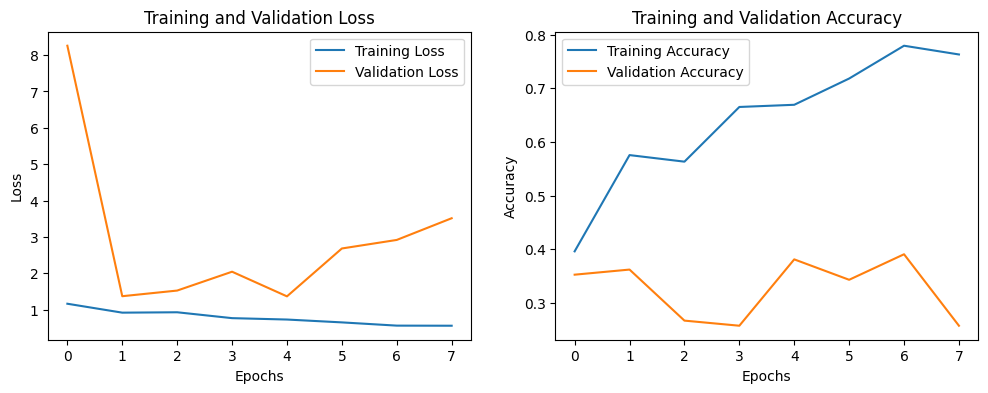

: 

In [10]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, GlobalAveragePooling3D, Dense, LSTM, TimeDistributed, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

base_path = "E:/2024t2/5925/violence-detection-dataset"
folders = ["high-level violence_frames", "low-level violence_frames", "non-violence_frames"]
labels = {"high-level violence_frames": 0, "low-level violence_frames": 1, "non-violence_frames": 2}

def load_data(folders, labels, base_path, frame_count=10):
    data = []
    targets = []

    for folder in folders:
        folder_path = os.path.join(base_path, folder)
        for video_folder in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_folder)
            frames = []
            for frame_file in sorted(os.listdir(video_path))[:frame_count]:
                frame_path = os.path.join(video_path, frame_file)
                frame = cv2.imread(frame_path)
                frame = cv2.resize(frame, (64, 64))
                frames.append(frame)
            if len(frames) < frame_count:
                frames.extend([np.zeros_like(frames[0])]*(frame_count - len(frames)))
            data.append(frames)
            targets.append(labels[folder])
    
    return np.array(data), np.array(targets)

data, targets = load_data(folders, labels, base_path)
data = np.expand_dims(data, axis=-1)
data = data / 255.0

X_train, X_val, y_train, y_val = train_test_split(data, targets, test_size=0.3, random_state=42)

def create_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling3D((2, 2, 2))(x)
    x = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D((2, 2, 2))(x)
    x = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling3D((2, 2, 2))(x)
    x = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling3D()(x)  # 使用全局池化层代替常规池化层
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

input_shape = (10, 64, 64, 3)
num_classes = 3

model = create_model(input_shape, num_classes)
model.summary()

# 创建早停回调
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16, callbacks=[early_stopping])

model.save('violence_detection_model.h8')

print("Finished training and saved as: violence_detection_model.h8")

# 绘制训练损失和验证损失曲线
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# 绘制训练精度和验证精度曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.show()


In [2]:


from nbconvert import HTMLExporter
from nbconvert.writers import FilesWriter
import nbformat

notebook_filename = '0712.ipynb'
with open(notebook_filename, 'r', encoding='utf-8') as f:
    notebook_content = f.read()
notebook_node = nbformat.reads(notebook_content, as_version=4)
html_exporter = HTMLExporter()
(body, resources) = html_exporter.from_notebook_node(notebook_node)

output_filename = 'output0712.html'
with open(output_filename, 'w', encoding='utf-8') as f:
    f.write(body)

print(f'Notebook has been converted to HTML and saved as {output_filename}')



Notebook has been converted to HTML and saved as output0712.html
